In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [ ]:
class InputEmbeddings(nn.Module):
  def __init__(self,d_model:int,vocab_size:int):
    super().__init__()
    self.d_model=d_model
    self.vocab_size=vocab_size
    self.embeddings=nn.Embedding(vocab_size,d_model)
  def forward(self,x):
    return self.embeddings(x)*math.sqrt(self.d_model)


# d_model refers to the dimensionality of the input and output representations.
# A larger d_model allows the model to capture more complex patterns and relationships in the data
# d_model is typically denoted as the size of the vectors used in the self-attention mechanism and the feed-forward networks within each Transformer layer.
# vocab_size is the total vocabulary size on which the model is trained on. Example on a entire langugae like english


In [ ]:
class PositionalEmbedding(nn.Module):
  def __init__(self,d_model:int,seq_len:int,dropout:float)->None:
    super().__init__()
    self.d_model=d_model
    self.seq_len=seq_len
    self.dropout=nn.Dropout(dropout)

    #create a matrix of shape (seq_len,d_model)
    pe=torch.zeros(seq_len,d_model)
    #For even positions use sin formula and for odd position use cos formula
    position=x=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))

    #Apply sin on even poistion and cos on odd position

    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)

    #Since we have batch of sentences we need to add extra dim to pe
    pe=pe.unsqueeze(0) # (1,seq_len,d_model)

    # Buffers are saved and loaded with the model’s state_dict.
    # This ensures that non-trainable states (like running statistics or masks) persist across
    # model saving and loading. They don't  update during backpropagation
    # Buffers are tracked by model.buffers() and saved with state_dict
    # It saves model training time when the model is loaded again.

    self.register_buffer('pe',pe)

  def forward(self,x):
    # Positional encoding for this particular sentence
    # We don't want to make the tensor learnable
    x=x+(self.pe[:,:x.shape[1],:]).requires_grad_(False)
    return self.dropout(x)
# seq_len-> is the length of the input sequence

# Layer Normalization

We calculate mean,var for each batch independent of other batches <br>
and update the values in the batch wrt there mean and var
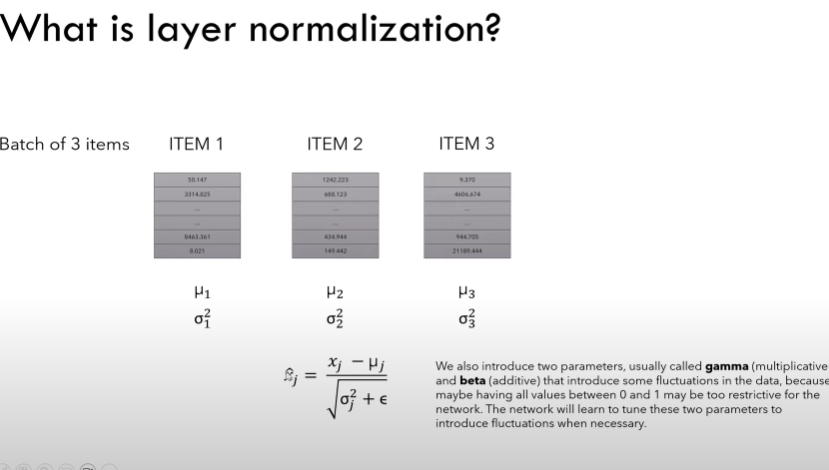

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self,eps:float=10**-6):
    super().__init__()
    self.eps=eps
    self.alpha=nn.Parameter(torch.ones(1)) #Multiplied
    self.bias=nn.Parameter(torch.zeros(1)) #Added
  def forward(self,x):
    #taking mean along the last dim of input (batch,seq_len,d_model)
    mean=x.mean(dim=-1,keepdim=True)
    std=x.std(dim=-1,keepdim=True)
    return self.alpha*(x-mean)/(std+self.eps)+self.bias

#Feed Forward Layer
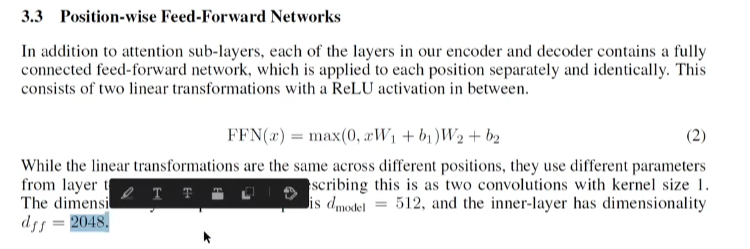

In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self,d_model:int,d_ff:int,dropout:float):
    super().__init__()
    self.linear1=nn.Linear(d_model,d_ff)
    self.dropout=nn.Dropout(dropout)
    self.linear2=nn.Linear(d_ff,d_model)
  def forward(self,x):
    # (Batch,seq_len,d_model)->(Batch,seq_len,d_ff)->(Batch,seq_len,d_model)
    x=self.linear1(x)
    x=torch.relu(x)
    x=self.dropout(x)
    x=self.linear2(x)
    return x

#d_ff->2048 and d_model->512 acc to paper

#Multihead Attention
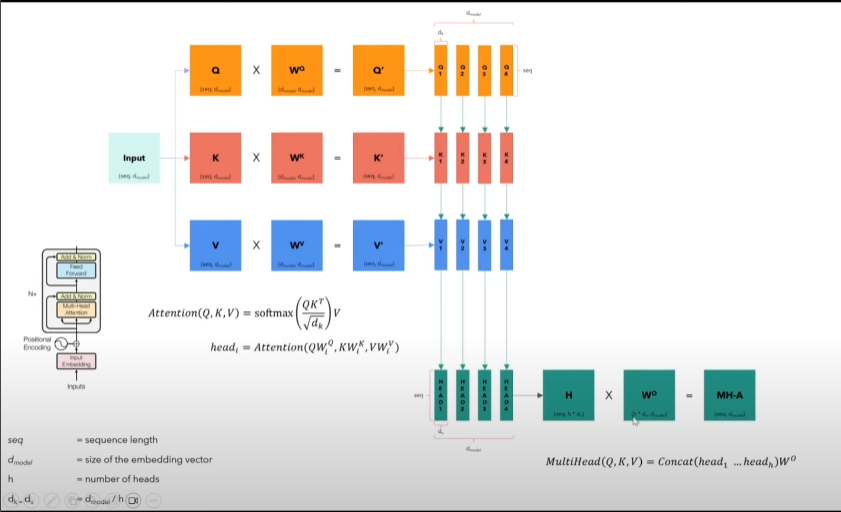

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self,d_model:int,h:int,dropout:float):
    super().__init__()
    self.d_model=d_model
    self.h=h
    assert d_model%h==0 #No. of head should be divisible by d_model
    self.d_k=d_model//h
    self.w_q=nn.Linear(d_model,d_model) #Wq
    self.w_v=nn.Linear(d_model,d_model) #Wv
    self.w_k=nn.Linear(d_model,d_model) #Wk
    self.w_o=nn.Linear(d_model,d_model) #Wo
    self.dropout=nn.Dropout(dropout)

    def forward(self,q,k,v,mask):
      query=self.w_q(q) #(batch,seq_len,d_model)
      key=self.w_k(k)
      value=self.w_v(v)

      # (batch,seq_len,d_model)->(batch,seq_len,h,d_k)->(batch,h,seq_len,d_k)
      query=query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2)
      key=key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
      value=value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2)

      x,self.attention_scores=MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout)

      #(batch,h,seq_len,d_k)->(batch,seq_len,d_model)
      x=x.transpose(1,2).contiguos().view(x.shape[0],-1,self.h*self.d_k)

      #
      return self.w_o(w)


    #Call method w/o creating instance of class
    @staticmethod
    def attention(query,key,value,mask,dropount:nn.Dropout):
      d_k=query.shape[-1]


      #(batch,h,seq_len,d_k)->(batch,h,seq_len,seq_len)
      attention_scores=(query@key.transpose(-2,-1))/math.sqrt(d_k)
      if mask is not None:
        attention_scores.masked_fill(mask==0,-1e9)
      attention_scores=attention_scores.softmax(dim=-1)
      if dropout is not None:
        attention_scores=dropout(attention_scores)

      return (attention_scores@value),attention_scores

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self,dropout):
    super().__init__()
    self.dropout=nn.Dropout(dropout)
    self.norm=LayerNormalization()
  def forward(self,x,sublayer):
    return x+ self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self,self_attention_block,feed_forward_block,dropout):
    super().__init__()
    self.attention_block=self_attention_block
    self.feed_forward_block=feed_forward_block
    self.residual_connection=nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self,x,src_mask):
    x=self.residual_connection[0](x,lambda x:self.attention_block(x,x,x,src_mask))
    x=self.residual_connection[0](x,self.feed_forward_block)
    return x

class Encoder(nn.Module):
  def __init__(self,layers,nn.ModuleList):
    super().__init__()
    self.layers=layers
    self.norm=LayerNormalization()

  def forward(self,x,mask):
    for layer in self.layers:
      x=layer(x,mask)
    return x.norm(x)

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self,self_attention_block,cross_attention_block,feed_forward_block,dropout):
    super().__init__()
    self.self_attention_block=self_attention_block
    self.cross_attention_block=cross_attention_block
    self.feed_forward_block=feed_forward_block
    self.residual_connection=nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
  def forward(self,x,encoder_output,src_mask,tgt_mask):
    x=self.residual_connections[0](x,lambda x:self.self_attention_block(x,x,x,tgt_mask))
    x=self.residual_connections[1](x,lambda x:self.cross_attention_block(x,encoder_output,encoder_output,src_mask))
    x=self.residual_connections[2](x,self.feed_forward_block)
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self,layers:nn.ModuleList):
    super().__init__()
    self.layers=layers
    self.norm=LayerNormalization()
  def forward(self,x,encoder_output,src_mask,tgt_mask):
    for layer in self.layers:
      x=layer(x,encoder_output,src_mask,tgt_mask)
    return self.norm(x)

#Linear Layer in decoder

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self,d_model,vocab_size):
    super().__init__()
    self.proj=nn.Linear(d_model,vocab_size)
  def forward(self,x):
    return torch.log_softmax(self.proj(x),dim=-1)

#Transformer block

In [ ]:
class Transformer(nn.Module):
  def __init__(self,encoder,decoder,src_embedding,tgt_embedding,src_pos,tgt_pos,projection_layer):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.src_embedding=src_embedding
    self.tgt_embedding=tgt_embedding
    self.src_pos=src_pos
    self.tgt_pos=tgt_pos
    self.projection_layer=projection_layer

  def encode(self,src,src_mask):
    src=self.src_embedding(src)
    src=self.src_pos(src)
    return self.encoder(src,src_mask)

  def decode(self,encoder_output,src_mask,tgt,tgt_mask):
    tgt=self.tgt_embedding(tgt)
    tgt=self.tgt_pos(tgt)
    return self.decoder(tgt,encoder_output,src_mask,tgt_mask)

  def project(self,x):
    return self.projection_layer(x)

In [ ]:
def build_transformer(src_vocab,tgt_vocab,src_seq_len,tgt_seq_len,d_model:int = 512,n:int = 6,dropout:float=0.1,d_ff:int=2048):

  #Create embedding
  src_embedding=InputEmbeddings(d_model,src_vocab)
  tgt_embedding=InputEmbeddings(d_model,tgt_vocab)

  #Positional Encoding
  src_pos=PositionalEmbedding(d_model,src_seq_len,dropout)
  tgt_pos=PositionalEmbedding(d_model,tgt_seq_len,dropout)

  #Create encoder blocks
  encoder_blocks=[]
  for _ in range(n):
    encoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
    feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
    encoder_block=EncoderBlock(encoder_self_attention_block,feed_forward_block,dropout)
    encoder_blocks.append(encoder_block)

  #Creating decoder blocks
  decoder_blocks=[]
  for _ in range(n):
    decoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
    decoder_cross_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
    feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
    decoder_block=DecoderBlock(decoder_self_attention_block,decoder_cross_attention_block,feed_forward_block,dropout)
    decoder_blocks.append(decoder_block)


  #Creating encoder and decoder
  encoder=Encoder(nn.ModuleList(encoder_blocks))
  decoder=Decoder(nn.ModuleList(decoder_blocks))

  #Projection layer
  projection_layer=projection_layer(d_model,tgt_vocab)

  #Creating transformer
  transformer=Transformer(encoder,decoder,src_embedding,tgt_embedding,src_pos,tgt_pos,projection_layer)

  #Intialize transformer
  for p in transformer.parameters():
    if p.dim()>1:
      nn.init.xavier_uniform_(p)
  return transform